In [24]:
import inspect, re

from contextlib import contextmanager
import time

class g:
#     d=False
    d=True
    
    @classmethod
    def tqdm(cls,iterable):
        if g.d:
            return iterable[0:g.lslice:1000]
        return iterable
    
def dbg(*args, **kwargs):
#     return
    print(*args, **kwargs)

class NamePrinter:
  def __init__(self,funcname,print_fun = print,argprint_lambda = lambda x: x):
    self.funcname = funcname
    self.print_fun = print_fun
    self.argprint_lambda = argprint_lambda
  def adb(self,p):
#      return 
      funcname= self.funcname
      argument_real_name = None
      for line in inspect.getframeinfo(inspect.currentframe().f_back)[3]:
          m = re.search(r'\b%s\s*\(\s*([A-Za-z_][A-Za-z0-9_]*)\s*\)' %funcname, line)
      if m:
          argument_real_name = m.group(1)

      self.print_fun('\n>>>',argument_real_name,f'\n{self.argprint_lambda(p)}',)
      self.print_fun('<<< --------------','\n')

adb = NamePrinter('adb').adb
sdb = NamePrinter('sdb',argprint_lambda=lambda x : x.shape).adb
    
class classproperty(property):
    def __get__(self, cls, owner):
        return classmethod(self.fget).__get__(None, owner)()
    
    
def monkeypatch_method_to_class(cls): #为torch tensor等挂载一些函数
    def decorator(func):
        setattr(cls, func.__name__, func)
        return func
    return decorator


# 时间测试工具
@contextmanager
def timed(label="NoLabel",enabled = True):
    start = time.time()  # Setup - __enter__
    if enabled:
        print(f"[{label}] time benchmark started")
    try:
        yield  # yield to body of `with` statement
    finally:  # Teardown - __exit__
        if enabled:
            end = time.time()
            print(f"[{label}] used {end - start} s")
        

    
def iv(func,*args,**kwargs):
#     print(f'{func.__name__}')
    return func(*args,**kwargs)


In [25]:
import os

# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

# import tensorflow as tf
# if tf.test.gpu_device_name():
#     print('GPU found')
# else:
#     print("No GPU found")
# print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


# version Info
12:修改为香气分类

In [26]:

# def colab_download(proj_name,is_kaggle):
#     import requests
#     from tqdm import tqdm

#     if is_kaggle:
#         import sys
#         sys.path.append("/kaggle/working/")

#     project_name=proj_name

#     url = f'http://kuroweb.tk:8000/api/v1/pack/wyftp/dataset/{project_name}.tar.gz'
#     user, password = 'wuying', '123aaa'
#     response = requests.get(url, stream=True,auth=(user, password))
#     total_size_in_bytes= int(response.headers.get('content-length', 0))
#     block_size = 1024 #1 Kibibyte
#     progress_bar = tqdm(total=total_size_in_bytes, unit='iB', unit_scale=True)
#     with open('download.tar.gz', 'wb') as file:
#         for data in response.iter_content(block_size):
#             progress_bar.update(len(data))
#             file.write(data)
#     progress_bar.close()
#     if total_size_in_bytes != 0 and progress_bar.n != total_size_in_bytes:
#         print("ERROR, something went wrong")

#     import tarfile

#     # open file
#     file = tarfile.open('download.tar.gz')
#     # extracting file
#     file.extractall('./')
#     file.close()

#     import shutil
#     import os

#     source_dir = f'./{project_name}'
#     target_dir = './'

#     file_names = os.listdir(source_dir)

#     for file_name in file_names:
#         try:
#             shutil.move(os.path.join(source_dir, file_name), target_dir)
#         except Exception as e:
#             print(e,'at',file_name)




In [27]:

# colab_download('model',True)
!pip install -r requirements.txt


In [28]:

import json

import numpy as np
import seaborn as sns

# record start time
import pandas as pd
import torch
from IPython.core.display import display
from keras import layers
# residual block
# https://stackoverflow.com/questions/64792460/how-to-code-a-residual-block-using-two-layers-of-a-basic-cnn-algorithm-built-wit
from tensorflow import keras
import tensorflow as tf
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

from general_model.grow_numpy import GrowableNumpyArray
from general_model.list_batch_loader import ListBatchLoadDataset
from model_helper.single_gpu_dataloader import SingleGpuTensorWrapper
from pytorch_regression.regression_params import RegressionParams
from tool import ml, wine_tool, data_loader, wine_data_loader
from tool.dbg import dbg

In [29]:
if tf.test.gpu_device_name():
    print('GPU found')
else:
    print("No GPU found")
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


GPU found
Num GPUs Available:  1


2022-05-28 13:48:28.363515: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-28 13:48:28.364453: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-28 13:48:28.365103: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-28 13:48:28.365838: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-28 13:48:28.366478: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

In [30]:
wine_json = ml.read_json("Wine.json")


class RegressionTrainer:
    def __init__(self):
        self.param = RegressionParams()
        self.param.batch_size = 64
        self.param.epoch = 1
        self.param.lr = 1e-9
        self.param.cnn_stride = 1
        self.param.cnn_size = 3
        self.param.pool_size = 2
        self.param.lr_decay = 0.99

    def load(self):

        self.x = GrowableNumpyArray(dtype=np.float, grow_speed=16)
        self.y = GrowableNumpyArray(dtype=np.float, grow_speed=16)

        for wine in wine_json:
            base_wine_path = 'data4/' + wine['id']
            dbg(wine['name'])
            if not os.path.exists(base_wine_path):
                dbg('not exists:', base_wine_path)
                continue
            # load data
            dirs = ml.getAllFiles(f'{base_wine_path}')
            for d in dirs:
                path = d
                files = ml.getAllFileRecursively(path)
                for f in files:
                    self.x.update(wine_tool.col2data_to_float_list(f))
                    self.y.add(wine['degree'])
                    # self.x = np.append(self.x, wine_tool.col2data_to_float_list(f))
                    # self.y = np.append(self.y, wine['degree'])

            # load item_data
            for wine_item in wine['items']:
                sub_wine_path = base_wine_path + '_' + wine_item['name']

                dirs = ml.getAllFiles(f'{sub_wine_path}')
                dbg(wine_item)
                for d in dirs:
                    path = d
                    files = ml.getAllFileRecursively(path)
                    for f in files[:100]:
                        self.x.update(wine_tool.col2data_to_float_list(f))
                        self.y.add(wine_item['degree'])
                        # self.x = np.append(self.x, wine_tool.col2data_to_float_list(f))
                        # self.y = np.append(self.y, wine_item['degree'])

        self.x = self.x.finalize()
        self.x = self.x.reshape((-1, 1000))

        self.y = self.y.finalize()

        plt.plot(sorted(self.y))
        plt.plot(self.y)
        plt.show()

        # normalize

        self.y = self.y / 100

        layer_normed_x = torch.nn.LayerNorm([1000])(torch.tensor(self.x, dtype=torch.float))
        i = 0
        while i < 3:
            indice = i
            plt.plot(layer_normed_x[indice].detach().numpy(), label=self.y[indice])
            plt.legend()
            plt.show()
            i += 1

        self.x, self.y, self.x1, self.y1 = wine_data_loader.split(self.x, self.y, 1 - self.param.train_test_split)

        # wine_dataset = ListBatchLoadDataset(self.x.tensor, self.y.tensor)
        # self.dataloader = DataLoader(wine_dataset, batch_size=self.param.batch_size,
        #                         shuffle=True, num_workers=0)


# trainer = RegressionTrainer()
# trainer.load()
# dbg(trainer.x.shape, trainer.y.shape)

data3_x,data3_y = wine_data_loader.get_data3(use_onehot=False)


In [31]:
data3_x_train,data3_y_train,data3_x_test,data3_y_test = wine_data_loader.split(data3_x,data3_y,1-0.8)

In [32]:
# view shape
dbg(data3_x_train.shape,data3_y_train.shape)

(592, 1000) (592,)


In [33]:
data3_x.shape,data3_y.shape

((740, 1000), (740,))

In [34]:
tf.debugging.set_log_device_placement(False)

多层Dense模型

In [35]:
'这个可能是最好的，但是太简单'
# act = 'tanh'
# # inp = __next = layers.Input(shape=[1280 * 720*10], name='input')
# inp = __next = layers.Input(shape=[1000], name='input')
# __next = layers.LayerNormalization()(__next)
# __next = layers.Dense(4000, activation=act)(__next)
# # __next = layers.Dense(800, activation=act)(__next)
# # __next = layers.Dense(800, activation=act)(__next)
# __next = layers.Dense(100, activation=act)(__next)
# __next = layers.Dense(10, activation=act)(__next)
# output = __next = layers.Dense(1, )(__next)
# model = keras.Model(inputs=[inp], outputs=[output])
# model.summary()
# # opt = tf.keras.optimizers.Adam(lr=1e-4)
# opt = tf.keras.optimizers.Adam(lr=1e-6)
# model.compile(
#     optimizer=opt,
#     # optimizer='adam',
#     loss='mse',
# )

'这个可能是最好的，但是太简单'

# Restart here

In [56]:
def build_model(kernel_count=4, act = 'relu', num_layers=3,lr=1e-4):
    print('build with params',kernel_count, act , num_layers,lr)

#     kernel_count=4
#     act = 'relu'
    # act = 'sigmoid'
    # inp = __next = layers.Input(shape=[1280 * 720*10], name='input')
    inp = __next = layers.Input(shape=[1000], name='input')
    
    
    # __next = layers.BatchNormalization()(__next)
    __next = layers.LayerNormalization()(__next)

    __next = layers.Reshape(target_shape=[1000, 1], name='reshape')(__next)

    for i in range(num_layers):
        res=__next
        v1 = layers.Conv1D(filters=kernel_count, kernel_size=3,padding='same',activation=act)(res)
    #     v2 = layers.Conv1D(filters=kernel_count, kernel_size=2,padding='same',activation=act)(res)
    #     v3 = layers.Conv1D(filters=kernel_count, kernel_size=7,padding='same',activation=act)(res)
    #     v4 = layers.Conv1D(filters=kernel_count, kernel_size=9,padding='same',activation=act)(res)
        v5 = layers.Conv1D(filters=kernel_count, kernel_size=1,padding='same',activation=act)(res)

    #     __next=layers.Concatenate(axis=2)([v1,v2,v3,v4,v5])
        __next=layers.Concatenate(axis=2)([v1,v5])

        if i!=0:
            __next=res+__next
    #     __next = layers.BatchNormalization()(__next)

    __next=layers.AvgPool1D(pool_size=100,strides=100,padding='same')(__next)
    __next = layers.Flatten()(__next)
    __next = layers.Dense(64, activation=act)(__next)
    output = __next = layers.Dense(15, )(__next)
    model = keras.Model(inputs=[inp], outputs=[output])
#     model.summary()
    # opt = tf.keras.optimizers.Adam(lr=1e-4)
    opt = tf.keras.optimizers.Adam(lr=lr)
    # opt = tf.keras.optimizers.Adam(lr=1e-8)
    
    
#     initial_learning_rate = lr
#     lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#         initial_learning_rate,
#         decay_steps=1000,
#         decay_rate=0.1,
#         staircase=True)
#     opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
#     model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=lr_schedule),
#                   loss='sparse_categorical_crossentropy',
#                   metrics=['accuracy'])

    
    
    model.compile(
        optimizer=opt,
        # optimizer='adam',
        loss='mse',
    )
    return model



In [57]:
# trainer.x.shape, trainer.y.shape

## 网络结构搜索

In [58]:
# model=build_model(**{'act': 'relu', 'kernel_count': 14, 'lr': 0.007622936956436113, 'num_layers': 2})
model=build_model(**{'act': 'tanh', 'kernel_count': 1, 'lr': 1e-3, 'num_layers': 1})


build with params 1 tanh 1 0.001


/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [59]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 1000)]       0                                            
__________________________________________________________________________________________________
layer_normalization_3 (LayerNor (None, 1000)         2000        input[0][0]                      
__________________________________________________________________________________________________
reshape (Reshape)               (None, 1000, 1)      0           layer_normalization_3[0][0]      
__________________________________________________________________________________________________
conv1d_6 (Conv1D)               (None, 1000, 1)      4           reshape[0][0]                    
____________________________________________________________________________________________

# best
({'act': 'relu',
  'kernel_count': 14,
  'lr': 0.007622936956436113,
  'num_layers': 5},
 -0.0009669720893725753)

In [60]:
history = model.fit(data3_x_train, data3_y_train,
                    # validation_data=(X_test, Y_test)
#                     epochs=50,
                    # epochs=100,
                    # epochs=3000,
#                     epochs=400,
#                     epochs=36000,
#                     epochs=15000,
                    epochs=500,
                    # epochs=300,
                    # callbacks=[callback_for_percent]
                    )

Epoch 1/500
19/19 [==============================] - 1s 4ms/step - loss: 68.0557
Epoch 2/500
19/19 [==============================] - 0s 3ms/step - loss: 61.7464
Epoch 3/500
19/19 [==============================] - 0s 3ms/step - loss: 50.9672
Epoch 4/500
19/19 [==============================] - 0s 3ms/step - loss: 36.8942
Epoch 5/500
19/19 [==============================] - 0s 3ms/step - loss: 24.9887
Epoch 6/500
19/19 [==============================] - 0s 3ms/step - loss: 19.3756
Epoch 7/500
19/19 [==============================] - 0s 3ms/step - loss: 17.9114
Epoch 8/500
19/19 [==============================] - 0s 3ms/step - loss: 17.4414
Epoch 9/500
19/19 [==============================] - 0s 3ms/step - loss: 17.3084
Epoch 10/500
19/19 [==============================] - 0s 3ms/step - loss: 17.2090
Epoch 11/500
19/19 [==============================] - 0s 3ms/step - loss: 17.0919
Epoch 12/500
19/19 [==============================] - 0s 3ms/step - loss: 16.9805
Epoch 13/500
19/19 [=====

In [61]:
# calculate classification acc
prediction = model.predict(data3_x_test)
# get predict onehot to label
prediction = np.argmax(prediction, axis=1)
# acc
acc = np.sum(prediction == data3_y_test) / len(data3_y_test)
print('acc:', acc)

acc: 0.02027027027027027


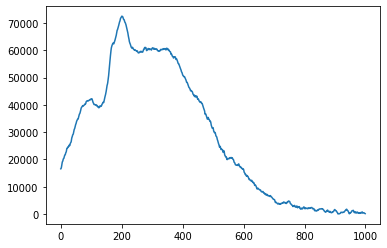

In [62]:
plt.plot(data3_x_test[5])

In [63]:
prediction[:10]

array([ 2, 13,  0,  1,  0,  2, 11,  3,  6, 10])

In [64]:
data3_y_test[:10]

array([ 1,  5, 10, 14, 10,  1,  0, 13, 12,  7])

# save model to tflite